# Human Resources: Employee Retention

In [38]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

%matplotlib inline

sns.set(style="whitegrid", color_codes=True)
sns.set_context("paper", font_scale=1.8)

In [2]:
hr_df = pd.read_csv("data/HR.csv")
hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
hr_df.shape

(14999, 10)

## Initial Cleaning

In [4]:
hr_df = hr_df.rename(columns = {'average_montly_hours':'average_monthly_hours',
                                'time_spend_company':'time_spent_company'}) 

## EDA

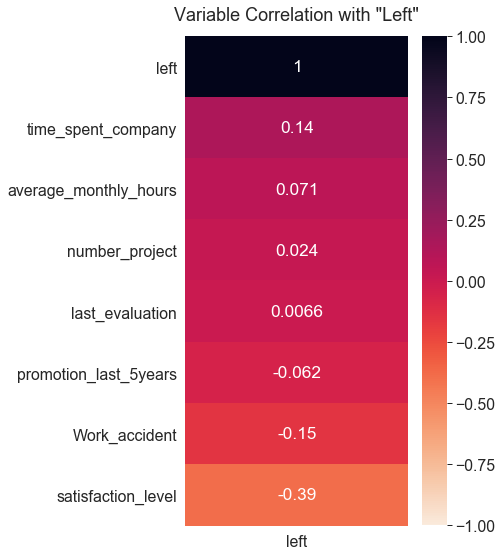

In [5]:
plt.figure(figsize=(5, 9))
heatmap = sns.heatmap(hr_df.corr()[['left']].sort_values(by='left', ascending=False), vmin=-1, vmax=1, annot=True, cmap='rocket_r')
heatmap.set_title('Variable Correlation with "Left"', fontdict={'fontsize':18}, pad=16);

Looking at the Correlation Heatmap it looks as if the top 5 factors for employee retention are:

1) Employee Satisfaction Level

2) Whether or Not the Employee was in a Work Accident

3) Time Employee has Spent with the Company

4) Employees Average Monthly Hours

5) Whether or Not the Employee was Promotted in the Last 5 Years


_______________________________________________________________________________________
I suspect not many employees have had a work accident so I am looking into this further


In [6]:
hr_df['Work_accident'].value_counts()

0    12830
1     2169
Name: Work_accident, dtype: int64

16.9% of employees have has work accidents, this may be high enough to leave in for my analysis. I will try it with and without.
______________________________________

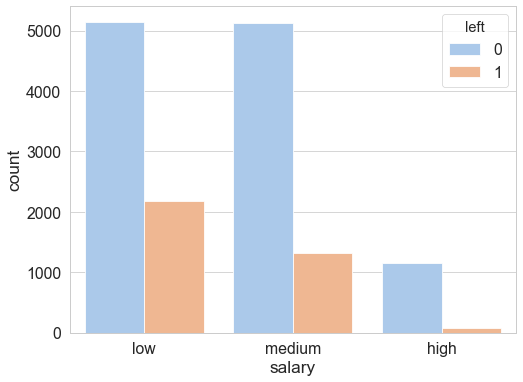

In [7]:
fig, bar_salary = plt.subplots(figsize = (8,6))
bar_salary = sns.countplot(x ='salary', hue = "left", data = hr_df, palette = ("pastel"))

In [8]:
#low salary
hr_df[hr_df['salary'] == 'low'].groupby(["left"])[['salary']].count()

,salary
left,
0,5144
1,2172


In [9]:
#medium salary
hr_df[hr_df['salary'] == 'medium'].groupby(["left"])[['salary']].count()

,salary
left,
0,5129
1,1317


In [10]:
#high salary
hr_df[hr_df['salary'] == 'high'].groupby(["left"])[['salary']].count()

,salary
left,
0,1155
1,82


Percent with low salary that left: 42.2%

Percent with medium salary that left: 25.7%

Percent with high salary that left: 7.1%


Salary has a high impact on whether or not an employee will leave the following year.

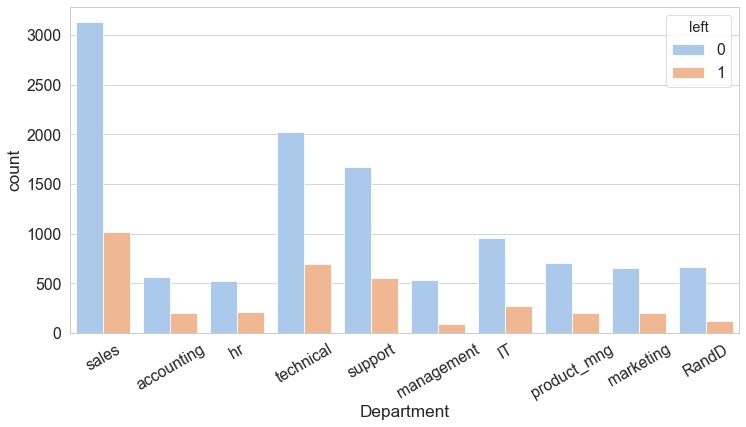

In [11]:
fig, bar_dep = plt.subplots(figsize = (12,6))
bar_dep = sns.countplot(x ='Department', hue = "left", data = hr_df, palette = ("pastel"))

for item in bar_dep.get_xticklabels():
    item.set_rotation(30)

In [12]:
# Checking a few Departments

# Sales Department
hr_df[hr_df['Department'] == 'sales'].groupby(["left"])[['Department']].count()

,Department
left,
0,3126
1,1014


In [13]:
# HR Department
hr_df[hr_df['Department'] == 'hr'].groupby(["left"])[['Department']].count()

,Department
left,
0,524
1,215


In [14]:
# Technical Department
hr_df[hr_df['Department'] == 'technical'].groupby(["left"])[['Department']].count()

,Department
left,
0,2023
1,697


In [15]:
# Support Department
hr_df[hr_df['Department'] == 'support'].groupby(["left"])[['Department']].count()

,Department
left,
0,1674
1,555


Percent in Sales that left: 32.4%

Percent in HR that left: 41%

Percent in Technical that left: 34.5%

Percent in Support that left: 33.2%

These percents are much closer to each other, so I am not going to use department in my analysis.

# Cleaning Data

I am choosing to remove the columns "number_project", "last_evaluation", and "department", because they do not have a strong correlation with whether or not the employee left the company the following year.

The highest accuracy number I got was by including the top 5 higest correlated numerical variables except for the "Work accident" variable as well as the "salary" categorical variable.

In [16]:
# subsetting for variables I want to use
hr_df_subset = hr_df[['satisfaction_level','average_monthly_hours','time_spent_company','promotion_last_5years','salary']]
hr_df_subset.head()

,satisfaction_level,average_monthly_hours,time_spent_company,promotion_last_5years,salary
0,0.38,157,3,0,low
1,0.80,262,6,0,medium
2,0.11,272,4,0,medium
3,0.72,223,5,0,low
4,0.37,159,3,0,low


## Cleaning Categorical Variables

Created dummy variables for the salary column

In [17]:
# making dummy variables for salary
salary_dummies = pd.get_dummies(hr_df_subset.salary, prefix="salary")

In [18]:
# adding dummy variable collmns to the subsetted hr df
hr_df_for_sklearn = pd.concat([hr_df_subset,salary_dummies],axis='columns')

In [19]:
#dropping salary column now that I have dummies
hr_df_for_sklearn = hr_df_for_sklearn.drop('salary', axis = 1)

In [20]:
hr_df_for_sklearn.head()

,satisfaction_level,average_monthly_hours,time_spent_company,promotion_last_5years,salary_high,salary_low,salary_medium
0,0.38,157,3,0,0,1,0
1,0.80,262,6,0,0,0,1
2,0.11,272,4,0,0,0,1
3,0.72,223,5,0,0,1,0
4,0.37,159,3,0,0,1,0


## Logistic Regression With Standardizing Independent Features

In [21]:
# setting df with variables for prediction
X = hr_df_for_sklearn

#list of whether they left or not
y = hr_df.left

In [22]:
# standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# splitting into testing and training
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,train_size=0.7, random_state = 42)

In [24]:
# setting up the model for logistic regression
model = LogisticRegression()

In [25]:
# fitting model
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# predicting my testing set
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
# checking accuracy score
model.score(X_test,y_test)

0.7591111111111111

## Logistic Regression Without Standardizing Independent Features

In [28]:
# setting df with variables for prediction
X = hr_df_for_sklearn

#list of whether they left or not
y = hr_df.left

In [29]:
# splitting into testing and training
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state = 42)

In [30]:
# setting up the model for logistic regression
model = LogisticRegression()

In [31]:
# fitting model
model.fit(X_train, y_train)

C:\Users\savro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
# predicting my testing set
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
# checking accuracy score
model.score(X_test,y_test)

0.7622222222222222

## Random Forest

In [34]:
# Using the X_scaled and y defined about in the logistic regression portion
# splitting into testing and training
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,train_size=0.7, random_state = 42)

In [35]:
# setting up the classifier
classifier = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
# predicting on the test set
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [39]:
# checking accuracy score
accuracy_score(y_test, y_pred)

0.9771111111111112

## Conclusion

The random forest model worked better with an accuracy score of 97.6%.

I am going to use the predicive probabilities from the random forest to predict if each employee in my testing set will leave or stay.

In [40]:
#viewing predictions as a decimal
model.predict_proba(X_test)

array([[7.67075555e-01, 2.32924445e-01],
       [9.75183391e-01, 2.48166090e-02],
       [6.82906339e-01, 3.17093661e-01],
       ...,
       [8.81604734e-01, 1.18395266e-01],
       [9.95799523e-01, 4.20047661e-03],
       [9.99997016e-01, 2.98409224e-06]])

In [41]:
# creating lists of probabilities as percents

first_list = []
second_list = []
for i in model.predict_proba(X_test):
    first = "{:.2f}".format(i[0]*100)
    second = "{:.2f}".format(i[1]*100)
    first_list.append(first + "%")
    second_list.append(second + "%")

In [42]:
data = {#'Banknote_Number':  bank_numbers,
        'Predicted_Value':  y_pred,
        'Percent_Chance_Not_Leaving': first_list,
        'Percent_Chance_Leaving':  second_list
        }

percents_df = pd.DataFrame (data, columns = ['Predicted_Value','Percent_Chance_Not_Leaving','Percent_Chance_Leaving'])

In [43]:
percents_df.head(10)

,Predicted_Value,Percent_Chance_Not_Leaving,Percent_Chance_Leaving
0,0,76.71%,23.29%
1,0,97.52%,2.48%
2,0,68.29%,31.71%
3,1,2.55%,97.45%
4,0,97.11%,2.89%
5,0,74.81%,25.19%
6,0,99.37%,0.63%
7,0,0.05%,99.95%
8,0,0.26%,99.74%
9,0,0.16%,99.84%


## Plotting ROC

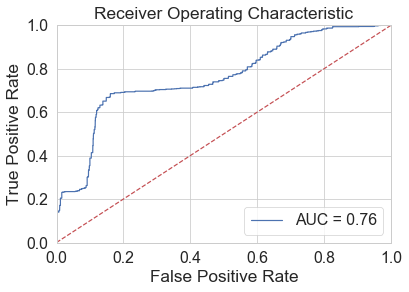

In [44]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:
metrics.auc(fpr, tpr)

0.7617035791723994